In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score

from common.data_frame_columns import PM10, PM2_5, PM1
from common.date_time_helper import convert_to_datetime
from common.endpoints_urls import endpoints_config
from common.working_dataset_config import working_datetime, test_date_time_strings
from data_management.data_crawler import DataManager
from data_management.data_reshaper import reshape_data, prepare_dataset, flatten_data
from data_management.labeled_data_generator import LabeledDataGenerator, DataLabel
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, recall_score, f1_score


In [2]:
class KNNClassifier:
    def __init__(self, neighbours, metric):
        self.knn = KNeighborsClassifier(n_neighbors=neighbours, metric=metric)

    def fit_data(self, labeled_data, columns):
        X, y = prepare_dataset(labeled_data, columns)
        X = flatten_data(X)
        self.knn.fit(X, y)

    def test_accuracy(self, labeled_data, columns):
        X_set, y_set = prepare_dataset(labeled_data, columns)
        X_set = flatten_data(X_set)
        predicted = self.knn.predict(X_set)
        accuracy = accuracy_score(y_set, predicted)
        precision = precision_score(y_set, predicted, average='weighted')
        recall = recall_score(y_set, predicted,  average='weighted')
        f1 = f1_score(y_set, predicted, average='weighted', zero_division=np.nan)
        # print("Accuracy of KNN: ", accuracy)
        # wrong_predicitons = [[DataLabel(p), DataLabel(y)] for p, y in zip(predicted, y_set) if p != y]
        # print("[Predicted, Actual]")
        # for error in wrong_predicitons:
        #     print(str(error[0]) + ", " + str(error[1]))
        return accuracy, precision, recall, f1


In [3]:
date_strings = ['01.01.2021 00:00', '31.12.2023 23:59']
test_dates_string = ['01.01.2024 00:00', '30.04.2024 23:59']

training_dates = [convert_to_datetime(date_strings[0]), convert_to_datetime(date_strings[1])]
test_dates = [convert_to_datetime(test_dates_string[0]), convert_to_datetime(test_dates_string[1])]

datas = DataManager(True).get_all_endpoints_data(endpoints_config, update=False)

column = PM10
L = LabeledDataGenerator(column)

test_data = L.generate_labeled_data(datas[:1], test_dates[0], test_dates[1], 50)
single_data = L.generate_labeled_data(datas[:1], training_dates[0], training_dates[1], 50)
multi_data = L.generate_labeled_data(datas, training_dates[0], training_dates[1], 50)

Loading station data: Gronie  https://datahub.ki.agh.edu.pl/api/endpoints/70/data/
    # Minimal data: 2022-07-13 23:38:02+00:00
    # Maximal data: 2024-05-10 16:16:39+00:00
Loading station data: Urząd Gminy  https://datahub.ki.agh.edu.pl/api/endpoints/71/data/
    # Minimal data: 2023-10-28 07:17:18+00:00
    # Maximal data: 2024-05-10 16:15:37+00:00
Loading station data: Młynne  https://datahub.ki.agh.edu.pl/api/endpoints/72/data/
    # Minimal data: 2022-02-12 21:11:18+00:00
    # Maximal data: 2024-05-10 16:15:59+00:00
Loading station data: Sucharskiego  https://datahub.ki.agh.edu.pl/api/endpoints/73/data/
    # Minimal data: 2021-10-07 19:41:43+00:00
    # Maximal data: 2024-05-10 16:19:11+00:00
Loading station data: Twardowskiego  https://datahub.ki.agh.edu.pl/api/endpoints/74/data/
    # Minimal data: 2021-10-07 20:59:56+00:00
    # Maximal data: 2024-05-10 16:20:04+00:00
Loading station data: Konopnickiej  https://datahub.ki.agh.edu.pl/api/endpoints/75/data/
    # Minimal data

In [4]:
from matplotlib import pyplot as plt

names_of_metrics = [
    'euclidean',
    'cityblock', 
    'cosine'
]
neighbours_max = 50
config_list = [
    {
        'name': 'knn_SDSC',
        'metrics': names_of_metrics,
        'columns': [PM10],
        'training_datas': single_data,
        'test_datas': test_data
    },
    {
        'name': 'knn_SDMC',
        'metrics': names_of_metrics,
        'columns': [PM10, PM1, PM2_5],
        'training_datas': single_data,
        'test_datas': test_data
    },
    {
        'name': 'knn_MDSC',
        'metrics': names_of_metrics,
        'columns': [PM10],
        'training_datas': multi_data,
        'test_datas': test_data
    },
    {
        'name': 'knn_MDMC',
        'metrics': names_of_metrics,
        'columns': [PM10, PM1, PM2_5],
        'training_datas': multi_data,
        'test_datas': test_data
    }
]

final_result = []
for metric in names_of_metrics:
   
    results = []
    for config in config_list:
        name = config['name']
        print(f'{metric} | {name}')
        n = []
        acc = []
        prec = []
        rec = []
        f1_s = []
        for i in range(1, neighbours_max):
            knn = KNNClassifier(i, metric)
            knn.fit_data(config['training_datas'], config['columns'])
            accuracy, precision, recall, f1 = knn.test_accuracy(config['test_datas'], config['columns'])
            n.append(i)
            acc.append(accuracy)
            prec.append(precision)
            rec.append(recall)
            f1_s.append(f1)

        results.append({
            "n": n,
            "acc": acc,
            'prec':prec,
            'recall':rec,
            'f1':f1_s,
            'name': name,
        })
    final_result.append({'result': results, 'metric': metric})

euclidean | knn_SDSC


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

euclidean | knn_SDMC


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

euclidean | knn_MDSC


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

euclidean | knn_MDMC


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

cityblock | knn_SDSC


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

cityblock | knn_SDMC


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

cityblock | knn_MDSC


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

cityblock | knn_MDMC


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

cosine | knn_SDSC


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

cosine | knn_SDMC


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

cosine | knn_MDSC


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

cosine | knn_MDMC


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

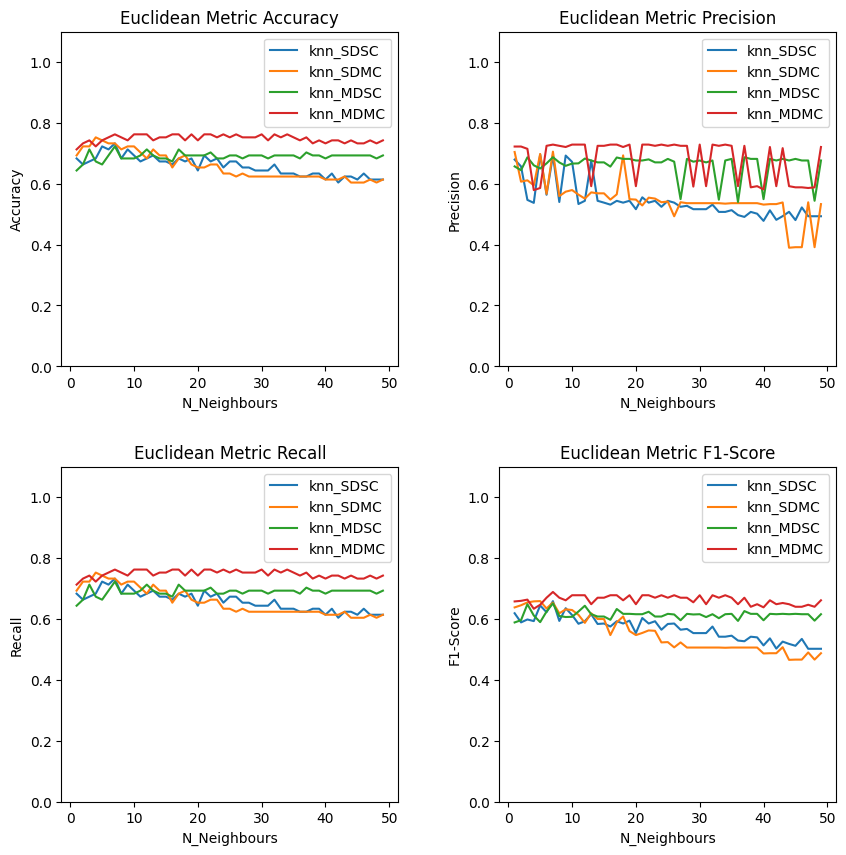

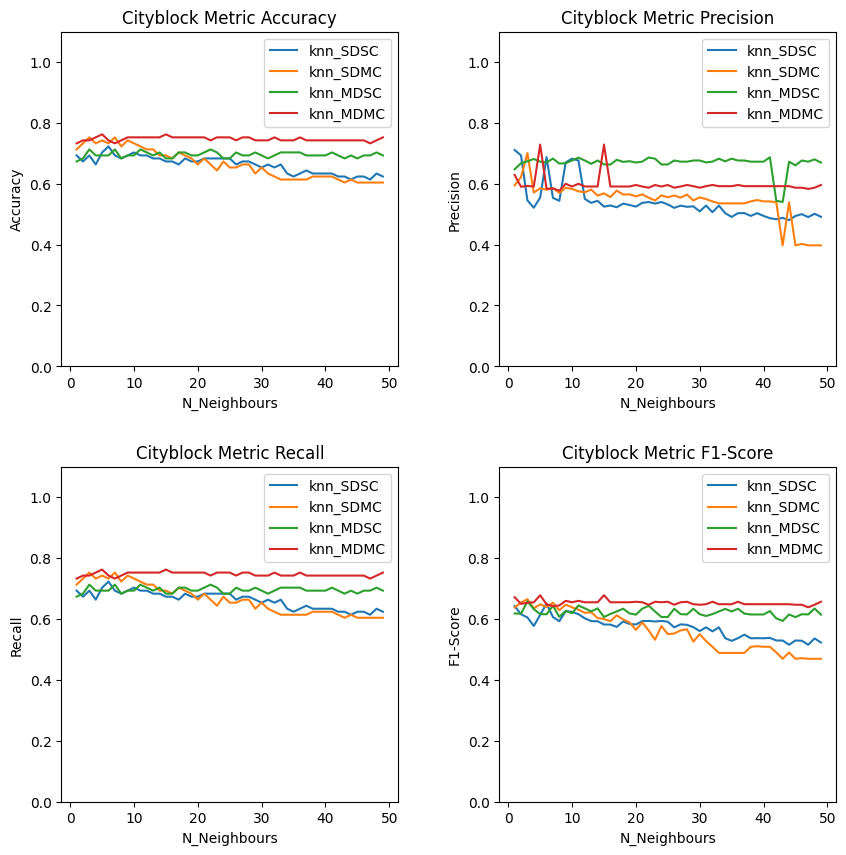

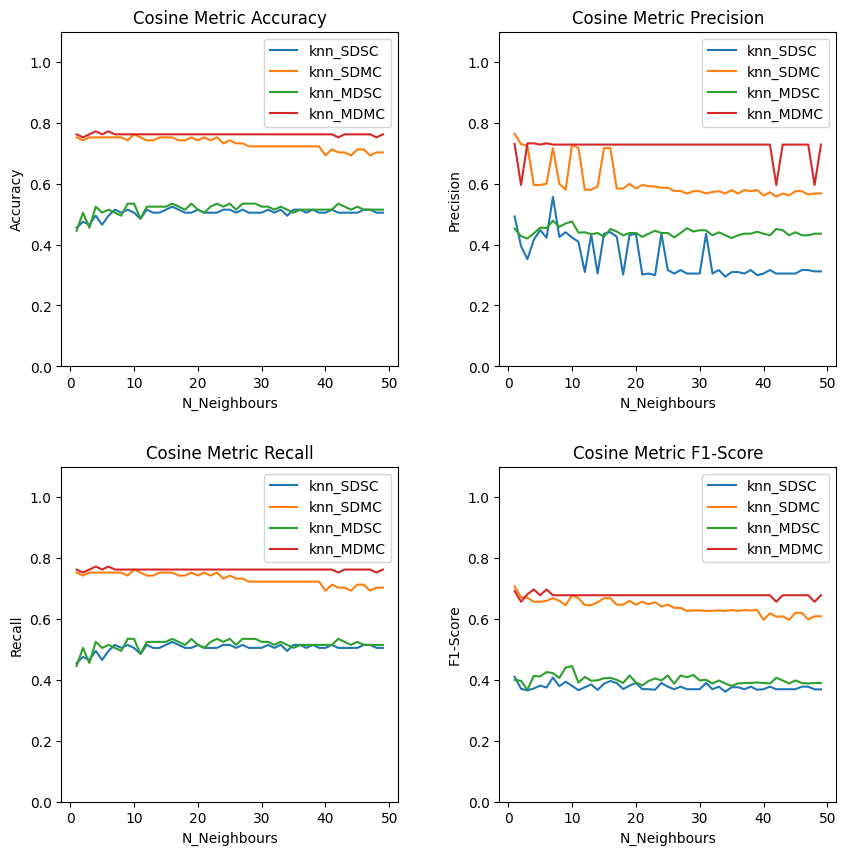

In [5]:
for setup in final_result:
    plt.figure(figsize=(10, 10))
    
    plt.subplot(2, 2, 1) 
    metric = setup['metric']
    plt.title((metric.title() + " Metric Accuracy"))
    plt.ylabel('Accuracy')
    plt.xlabel('N_Neighbours')
    plt.ylim(0.0, 1.1)
    for result in setup['result']:
       plt.plot(result['n'], result['acc'], label=result['name'])
    plt.legend()
        
    plt.subplot(2, 2, 2) 
    plt.title((metric.title() + " Metric Precision").title())
    plt.ylabel('Precision')
    plt.xlabel('N_Neighbours')
    plt.ylim(0.0, 1.1)
    for result in setup['result']:
        plt.plot(result['n'], result['prec'], label=result['name'])   
    plt.legend()
    
    plt.subplot(2, 2, 3) 
    plt.title((metric.title() + " Metric Recall").title())
    plt.ylabel('Recall')
    plt.xlabel('N_Neighbours')
    plt.ylim(0.0, 1.1)
    for result in setup['result']:
        plt.plot(result['n'], result['recall'], label=result['name']) 
    plt.legend()
    
    plt.subplot(2, 2, 4) 
    plt.title((metric.title() + " Metric F1-Score").title())
    plt.ylabel('F1-Score')
    plt.xlabel('N_Neighbours')
    plt.ylim(0.0, 1.1)
    for result in setup['result']:
       plt.plot(result['n'], result['f1'], label=result['name']) 
    plt.legend()
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

In [6]:
accuracy_final = []
for setup in final_result:
    for result in setup['result']:
        max = 0
        max_k = 0
        max_name = 0
        n = result['n']
        acc = result['acc']
        for i in range(len(n)):
            if acc[i] > max:
                max = acc[i]
                max_name = result['name']
                max_k = n[i]
        accuracy_final.append({'metric':setup['metric'] , 'acc': max, 'k': max_k, 'name': max_name})
    
for end in accuracy_final:
    print(end)
        
        
  

{'metric': 'euclidean', 'acc': 0.7326732673267327, 'k': 7, 'name': 'knn_SDSC'}
{'metric': 'euclidean', 'acc': 0.7524752475247525, 'k': 4, 'name': 'knn_SDMC'}
{'metric': 'euclidean', 'acc': 0.7227722772277227, 'k': 7, 'name': 'knn_MDSC'}
{'metric': 'euclidean', 'acc': 0.7623762376237624, 'k': 7, 'name': 'knn_MDMC'}
{'metric': 'cityblock', 'acc': 0.7227722772277227, 'k': 6, 'name': 'knn_SDSC'}
{'metric': 'cityblock', 'acc': 0.7524752475247525, 'k': 3, 'name': 'knn_SDMC'}
{'metric': 'cityblock', 'acc': 0.7128712871287128, 'k': 3, 'name': 'knn_MDSC'}
{'metric': 'cityblock', 'acc': 0.7623762376237624, 'k': 5, 'name': 'knn_MDMC'}
{'metric': 'cosine', 'acc': 0.5247524752475248, 'k': 16, 'name': 'knn_SDSC'}
{'metric': 'cosine', 'acc': 0.7623762376237624, 'k': 10, 'name': 'knn_SDMC'}
{'metric': 'cosine', 'acc': 0.5346534653465347, 'k': 9, 'name': 'knn_MDSC'}
{'metric': 'cosine', 'acc': 0.7722772277227723, 'k': 4, 'name': 'knn_MDMC'}


In [7]:
'''
{'metric': 'euclidean', 'acc': 0.6831683168316832, 'k': 14, 'name': 'knn_SDSC'}
{'metric': 'euclidean', 'acc': 0.7128712871287128, 'k': 3, 'name': 'knn_SDMC'}
{'metric': 'euclidean', 'acc': 0.6831683168316832, 'k': 9, 'name': 'knn_MDSC'}
{'metric': 'euclidean', 'acc': 0.7425742574257426, 'k': 9, 'name': 'knn_MDMC'}

{'metric': 'cityblock', 'acc': 0.7326732673267327, 'k': 5, 'name': 'knn_SDSC'}
{'metric': 'cityblock', 'acc': 0.7524752475247525, 'k': 1, 'name': 'knn_SDMC'}
{'metric': 'cityblock', 'acc': 0.7524752475247525, 'k': 1, 'name': 'knn_MDSC'}
{'metric': 'cityblock', 'acc': 0.7623762376237624, 'k': 7, 'name': 'knn_MDMC'}

{'metric': 'cosine', 'acc': 0.39603960396039606, 'k': 6, 'name': 'knn_SDSC'}
{'metric': 'cosine', 'acc': 0.7425742574257426, 'k': 6, 'name': 'knn_SDMC'}
{'metric': 'cosine', 'acc': 0.39603960396039606, 'k': 6, 'name': 'knn_MDSC'}
{'metric': 'cosine', 'acc': 0.7524752475247525, 'k': 7, 'name': 'knn_MDMC'}
'''




"\n{'metric': 'euclidean', 'acc': 0.6831683168316832, 'k': 14, 'name': 'knn_SDSC'}\n{'metric': 'euclidean', 'acc': 0.7128712871287128, 'k': 3, 'name': 'knn_SDMC'}\n{'metric': 'euclidean', 'acc': 0.6831683168316832, 'k': 9, 'name': 'knn_MDSC'}\n{'metric': 'euclidean', 'acc': 0.7425742574257426, 'k': 9, 'name': 'knn_MDMC'}\n\n{'metric': 'cityblock', 'acc': 0.7326732673267327, 'k': 5, 'name': 'knn_SDSC'}\n{'metric': 'cityblock', 'acc': 0.7524752475247525, 'k': 1, 'name': 'knn_SDMC'}\n{'metric': 'cityblock', 'acc': 0.7524752475247525, 'k': 1, 'name': 'knn_MDSC'}\n{'metric': 'cityblock', 'acc': 0.7623762376237624, 'k': 7, 'name': 'knn_MDMC'}\n\n{'metric': 'cosine', 'acc': 0.39603960396039606, 'k': 6, 'name': 'knn_SDSC'}\n{'metric': 'cosine', 'acc': 0.7425742574257426, 'k': 6, 'name': 'knn_SDMC'}\n{'metric': 'cosine', 'acc': 0.39603960396039606, 'k': 6, 'name': 'knn_MDSC'}\n{'metric': 'cosine', 'acc': 0.7524752475247525, 'k': 7, 'name': 'knn_MDMC'}\n"